In [104]:
import pandas as pd
import numpy as np
import re
from scipy.stats import chi2_contingency
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [105]:
file_path = '../data/clickdata.csv'
df = pd.read_csv(file_path)

In [106]:
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Browser Webview','Browser')
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Robot Mobile','Robot')
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Special','Other')
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Mobile App','Other')
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Cloud Application','Other')

In [107]:
# Convert epoch_ms to datetime
df['datetime'] = pd.to_datetime(df['epoch_ms'], unit='ms')
df = df.drop(columns=['epoch_ms'])
# Sort by session_id and datetime
df.sort_values(by=['session_id', 'datetime'], inplace=True)

# Calculate time differences between consecutive requests in the same session
df['time_diff'] = df.groupby('session_id')['datetime'].diff().dt.total_seconds().fillna(0)

In [108]:

# Custom function to calculate cumulative unique counts of non-null values
def cumulative_nunique(series):
    # return series.expanding().apply(lambda x: x.nunique(), raw=False)
    seen = set()
    unique_counts = []
    for item in series:
        if pd.notna(item):  # Only add non-null items to the set
            seen.add(item)
        unique_counts.append(len(seen))
    return unique_counts

# Custom function to calculate cumulative counts of non-null values
def cumulative_num_non_null(series):
    non_null_counts = series.notna().cumsum()
    return non_null_counts

# Session-level cumulative feature columns
df['cumulative_session_duration'] = df.groupby('session_id')['time_diff'].cumsum()
df['cumulative_num_unique_visitor_recognition_type'] = df.groupby('session_id')['visitor_recognition_type'].transform(cumulative_nunique)
df['cumulative_num_requests'] = df.groupby('session_id').cumcount() + 1
df['cumulative_num_unique_pages_visited'] = df.groupby('session_id')['url_without_parameters'].transform(cumulative_nunique)
df['cumulative_avg_time_between_requests'] = df['cumulative_session_duration'] / (df['cumulative_num_requests'] - 1).replace(0, 1)
df['cumulative_count_referer'] = df.groupby('session_id')['referrer_without_parameters'].transform(cumulative_num_non_null)
df['cumulative_num_unique_referer'] = df.groupby('session_id')['referrer_without_parameters'].transform(cumulative_nunique)

In [109]:
# Define a function to split the URL by '/'
def split_url(url):
    # Remove the domain part if it exists
    if 'https://www.bol.com/nl/' in url:
        url = url.replace('https://www.bol.com/nl/', '')
    return url.split('/')

# Apply the function to the 'url_without_parameters' column to create the 'url_split' column
df['url_split'] = df['url_without_parameters'].apply(split_url)

# Join the lists of URL segments into strings
df['url_string'] = df['url_split'].apply(lambda x: ' '.join(x))


In [110]:
# Function to extract URL features
def extract_url_features(url):
    features = {}
    features['url_length'] = len(url)
    features['url_depth'] = url.count('/')
    return features

# Apply feature extraction
df_features = df['url_without_parameters'].apply(extract_url_features).apply(pd.Series)

# Combine features with original DataFrame
df = pd.concat([df, df_features], axis=1)

In [111]:
df[df['session_id']=='028a1b7ceed94bd449bef22e1cf33a79']

session_id country_by_ip_address  \
9591   028a1b7ceed94bd449bef22e1cf33a79                    US   
43910  028a1b7ceed94bd449bef22e1cf33a79                    US   
52428  028a1b7ceed94bd449bef22e1cf33a79                    GB   
52433  028a1b7ceed94bd449bef22e1cf33a79                    GB   
52435  028a1b7ceed94bd449bef22e1cf33a79                    GB   
18087  028a1b7ceed94bd449bef22e1cf33a79                    GB   
18088  028a1b7ceed94bd449bef22e1cf33a79                    GB   
1105   028a1b7ceed94bd449bef22e1cf33a79                    GB   
35307  028a1b7ceed94bd449bef22e1cf33a79                    GB   
9609   028a1b7ceed94bd449bef22e1cf33a79                    GB   
43934  028a1b7ceed94bd449bef22e1cf33a79                    GB   
35316  028a1b7ceed94bd449bef22e1cf33a79                    GB   
9612   028a1b7ceed94bd449bef22e1cf33a79                    GB   
18107  028a1b7ceed94bd449bef22e1cf33a79                    GB   
18111  028a1b7ceed94bd449bef22e1cf33a79                    GB   
1130   028a1b7ceed94bd449bef22e1cf33a79                    GB   
52464  028a1b7ceed94bd449bef22e1cf33a79                    GB   
26699  028a1b7ceed94bd449bef22e1cf33a79                    GB   
52466  028a1b7ceed94bd449bef22e1cf33a79                    GB   
9625   028a1b7ceed94bd449bef22e1cf33a79                    GB   
26702  028a1b7ceed94bd449bef22e1cf33a79                    GB   
26709  028a1b7ceed94bd449bef22e1cf33a79                    US   
1151   028a1b7ceed94bd449bef22e1cf33a79                    PT   
52483  028a1b7ceed94bd449bef22e1cf33a79                    PT   
18147  028a1b7ceed94bd449bef22e1cf33a79                    PT   
35375  028a1b7ceed94bd449bef22e1cf33a79                    FI   
9652   028a1b7ceed94bd449bef22e1cf33a79                    FI   
52492  028a1b7ceed94bd449bef22e1cf33a79                    FI   
9660   028a1b7ceed94bd449bef22e1cf33a79                    US   
43997  028a1b7ceed94bd449bef22e1cf33a79                    US   
52507  028a1b7ceed94bd449bef22e1cf33a79                    US   
52511  028a1b7ceed94bd449bef22e1cf33a79                    US   
52514  028a1b7ceed94bd449bef22e1cf33a79                    US   

      region_by_ip_address                             url_without_parameters  \
9591                    AZ  https://www.bol.com/nl/p/flymo-haagschaar-easi...   
43910                   AZ  https://www.bol.com/nl/p/tectake-haagschaar-in...   
52428                  ENG  https://www.bol.com/nl/p/wolf-garten-boomschaa...   
52433                  ENG  https://www.bol.com/nl/l/tuin/tuingereedschap-...   
52435                  ENG  https://www.bol.com/nl/p/hofftech-buxusschaar-...   
18087                  ENG  https://www.bol.com/nl/p/powerplus-powxg2016-b...   
18088                  ENG  https://www.bol.com/nl/p/wolf-elektrische-hegg...   
1105                   ENG  https://www.bol.com/nl/p/flexovit-wetstenen-18...   
35307                  ENG  https://www.bol.com/nl/p/felco-910-lederen-hol...   
9609                   ENG  https://www.bol.com/nl/p/bosch-grasschaar-mes-...   
43934                  ENG  https://www.bol.com/nl/p/scheppach-multifuncti...   
35316                  ENG  https://www.bol.com/nl/p/takkenschaar-aambeeld...   
9612                   ENG  https://www.bol.com/nl/p/silverline-uitschuifb...   
18107                  ENG  https://www.bol.com/nl/p/felco-9-snoeischaar-l...   
18111                  ENG  https://www.bol.com/nl/p/kinzo-3-in-1-snoeisch...   
1130                   ENG  https://www.bol.com/nl/p/bladschaar-trimschaar...   
52464                  ENG  https://www.bol.com/nl/p/talen-tools-bloemensc...   
26699                  ENG  https://www.bol.com/nl/p/wolf-garten-batterij-...   
52466                  ENG  https://www.bol.com/nl/p/bosch-universalhedgec...   
9625                   ENG  https://www.bol.com/nl/p/gardena-powercut-li-4...   
26702                  ENG  https://www.bol.com/nl/p/groene-bloemensnijder...   
26709                   AZ  https://

In [112]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title='Dataset Profiling Report', explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [113]:
df.dtypes

session_id                                                object
country_by_ip_address                                     object
region_by_ip_address                                      object
url_without_parameters                                    object
referrer_without_parameters                               object
visitor_recognition_type                                  object
ua_agent_class                                            object
datetime                                          datetime64[ns]
time_diff                                                float64
cumulative_session_duration                              float64
cumulative_num_unique_visitor_recognition_type             int64
cumulative_num_requests                                    int64
cumulative_num_unique_pages_visited                        int64
cumulative_avg_time_between_requests                     float64
cumulative_count_referer                                   int64
cumulative_num_unique_ref

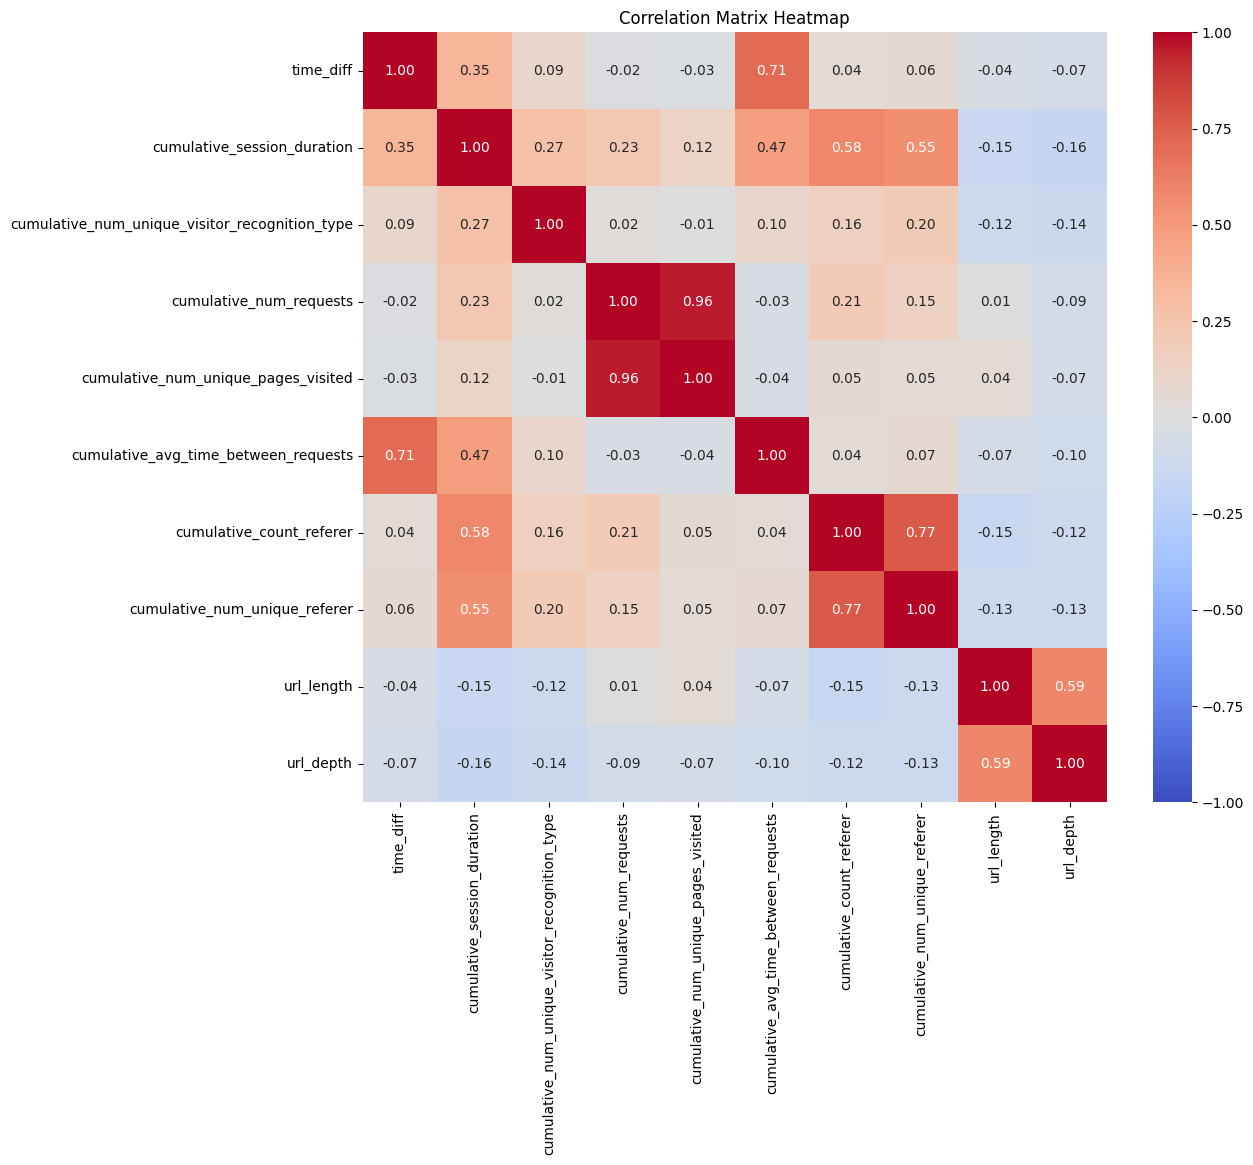

In [114]:
## Correlation analysis for numerical features
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

Logs are not complete!!

In [98]:
df

session_id country_by_ip_address  \
0      000339eb8412724e0ecd55e695fd5ea1                    US   
1      00070b81850bd8cf15019f8aa469820c                    US   
2      0007273f5ce02adbfbc3058f9e801cc5                    US   
3      0007d22c96b6168fd41b7a5360edee75                    FR   
4      000a3e043e0b4d9832c4ea10710502fd                    NL   
...                                 ...                   ...   
59777  fff6621ab803217e98f99f7328e46a40                    NL   
59778  fff7b8c890847fff585e61573c3667b5                    US   
59779  fffc13529d0f34dff188b214477e3327                    US   
59780  fffc1c7043c575997dec89551b295b67                    US   
59781  ffffb4fc4a1e5f4eb81fe99fcc5a712f                    US   

      region_by_ip_address                             url_without_parameters  \
0                       CA  https://www.bol.com/nl/l/juniwer-design-baby-p...   
1                       CA  https://www.bol.com/nl/p/modern-questions-of-c...   
2                       CA  https://www.bol.com/nl/c/gabrielli-players/256...   
3                      NaN  https://www.bol.com/nl/p/asus-versasleeve-7i-b...   
4                      NaN           https://www.bol.com/nl/s/ajax/index.html   
...                    ...                                                ...   
59777                   ZE  https://www.bol.com/nl/p/vidaxl-binnenfontein-...   
59778                   CA  https://www.bol.com/nl/l/engelstalige-outdoor-...   
59779                   CA  https://www.bol.com/nl/p/marcato-atlas-150-wel...   
59780                   CA  https://www.bol.com/nl/l/agenda-s-2018/N/25305...   
59781                   WA  https://www.bol.com/nl/s/elektronica/zoekresul...   

                             referrer_without_parameters  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3      https://www.bol.com/nl/p/asus-versasleeve-7i-b...   
4      https://www.bol.com/nl/s/elektronica/zoekresul...   
...                                                  ...   
59777                                                NaN   
59778                                                NaN   
59779                                                NaN   
59780                                                NaN   
59781                                                NaN   

      visitor_recognition_type ua_agent_class                datetime  \
0                    ANONYMOUS          Robot 2018-03-05 20:19:34.719   
1                    ANONYMOUS          Robot 2018-03-05 20:20:41.010   
2                    ANONYMOUS          Robot 2018-03-05 20:59:56.066   
3                    ANONYMOUS        Browser 2018-03-05 21:58:40.328   
4                   RECOGNIZED        Browser 2018-03-05 21:50:42.158   
...                        ...            ...                     ...   
59777                ANONYMOUS        Browser 2018-03-05 20:20:33.805   
59778                ANONYMOUS          Robot 2018-03-05 21:14:16.649   
59779                ANONYMOUS          Robot 2018-03-05 21:15:09.957   
59780                ANONYMOUS          Robot 2018-03-05 20:22:00.034   
59781                ANONYMOUS          Robot 2018-03-05 21:24:57.685   

       time_diff  cumulative_session_duration  \
0            0.0                          0.0   
1            0.0                          0.0   
2            0.0                          0.0   
3            0.0                          0.0   
4            0.0                          0.0   
...          ...                          ...   
59777        0.0                          0.0   
59778        0.0                          0.0   
59779        0.0                          0.0   
59780        0.0                          0.0   
59781        0.0                          0.0   

       num_unique_visitor_recognition_type  num_requests  \
0                           

In [99]:
df[df['datetime']==df['datetime'].min()]

session_id country_by_ip_address  \
18430  4a26ed5845d385a9e740aab697f52b17                    NL   

      region_by_ip_address                             url_without_parameters  \
18430                   GR  https://www.bol.com/nl/order/basket_bargains.html   

      referrer_without_parameters visitor_recognition_type ua_agent_class  \
18430                         NaN                ANONYMOUS        Browser   

                     datetime  time_diff  cumulative_session_duration  \
18430 2018-03-05 20:00:00.011        0.0                          0.0   

       num_unique_visitor_recognition_type  num_requests  \
18430                                    3            22   

       num_unique_pages_visited  session_duration  avg_time_between_requests  \
18430                        12          7109.317                 338.538905   

       count_referer                      url_split  \
18430              3  [order, basket_bargains.html]   

                       url_string  url_length  url_depth  
18430  order basket_bargains.html          49          5

In [100]:
df[df['session_id']=='4a26ed5845d385a9e740aab697f52b17']

session_id country_by_ip_address  \
18430  4a26ed5845d385a9e740aab697f52b17                    NL   
18431  4a26ed5845d385a9e740aab697f52b17                    NL   
18432  4a26ed5845d385a9e740aab697f52b17                    NL   
18433  4a26ed5845d385a9e740aab697f52b17                    NL   
18434  4a26ed5845d385a9e740aab697f52b17                    NL   
18435  4a26ed5845d385a9e740aab697f52b17                    NL   
18436  4a26ed5845d385a9e740aab697f52b17                    NL   
18437  4a26ed5845d385a9e740aab697f52b17                    NL   
18438  4a26ed5845d385a9e740aab697f52b17                    NL   
18439  4a26ed5845d385a9e740aab697f52b17                    NL   
18440  4a26ed5845d385a9e740aab697f52b17                    NL   
18441  4a26ed5845d385a9e740aab697f52b17                    NL   
18442  4a26ed5845d385a9e740aab697f52b17                    NL   
18443  4a26ed5845d385a9e740aab697f52b17                    NL   
18444  4a26ed5845d385a9e740aab697f52b17                    NL   
18445  4a26ed5845d385a9e740aab697f52b17                    NL   
18446  4a26ed5845d385a9e740aab697f52b17                    NL   
18447  4a26ed5845d385a9e740aab697f52b17                    NL   
18448  4a26ed5845d385a9e740aab697f52b17                    NL   
18449  4a26ed5845d385a9e740aab697f52b17                    NL   
18450  4a26ed5845d385a9e740aab697f52b17                    NL   
18451  4a26ed5845d385a9e740aab697f52b17                    NL   

      region_by_ip_address                             url_without_parameters  \
18430                   GR  https://www.bol.com/nl/order/basket_bargains.html   
18431                   GR  https://www.bol.com/nl/l/algemeen/topdeals/N/4...   
18432                   GR         https://www.bol.com/nl/checkout/login.html   
18433                   GR  https://www.bol.com/nl/order/basket_bargains.html   
18434                   GR  https://www.bol.com/nl/order/basket_bargains.html   
18435                   GR  https://www.bol.com/nl/account/bestellingen/ov...   
18436                   GR  https://www.bol.com/nl/p/smaakvrienden-fruit-z...   
18437                   GR  https://www.bol.com/nl/p/way-it-feels-lp-cd/92...   
18438                   GR  https://www.bol.com/nl/lijstjes/verlanglijstje...   
18439                   GR  https://www.bol.com/nl/p/smaakvrienden-fruit-z...   
18440                   GR  https://www.bol.com/nl/order/basket_bargains.html   
18441                   GR  https://www.bol.com/nl/order/basket_bargains.html   
18442                   GR          https://www.bol.com/nl/account/login.html   
18443                   GR  https://www.bol.com/nl/order/basket_bargains.html   
18444                   GR          https://www.bol.com/nl/checkout/paid.html   
18445                   GR           https://www.bol.com/nl/s/ajax/index.html   
18446                   GR  https://www.bol.com/nl/p/rojafit-luxe-budget-d...   
18447                   GR  https://www.bol.com/nl/order/basket_bargains.html   
18448                   GR  https://www.bol.com/nl/p/rojafit-luxe-budget-d...   
18449                   GR           https://www.bol.com/nl/s/ajax/index.html   
18450                   GR           https://www.bol.com/nl/s/ajax/index.html   
18451                   GR  https://www.bol.com/nl/p/iittala-origo-papiere...   

                             referrer_without_parameters  \
18430                                                NaN   
18431                                                NaN   
18432                                                NaN   
18433                                                NaN   
18434                                                NaN   
18435       https://www.bol.com/nl/chckout/checkout.html   
18436                                                NaN   
18437                                                NaN   
18438                                                NaN   
18439                                                NaN   
18440    

There might be other logs outside the time range. This session is so long!!! two hours!!! usually it is 30 mins

# Train test split
Two conditions:
- session based
-  stratified split

In [115]:
# Extract unique session IDs and their corresponding ua_agent_class
session_class = df.groupby('session_id')['ua_agent_class'].first().reset_index()

# Initialize StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_idx, test_idx in split.split(session_class['session_id'], session_class['ua_agent_class']):
    train_sessions = session_class['session_id'].iloc[train_idx]
    test_sessions = session_class['session_id'].iloc[test_idx]

# Create training and test sets based on session IDs
train_df = df[df['session_id'].isin(train_sessions)]
test_df = df[df['session_id'].isin(test_sessions)]

# Display the number of sessions in train and test sets
print(f"Number of sessions in training set: {len(train_sessions)}")
print(f"Number of sessions in test set: {len(test_sessions)}")

# Check the distribution of ua_agent_class in both sets
print("Distribution in training set:")
print(train_df['ua_agent_class'].value_counts(normalize=True))

print("Distribution in test set:")
print(test_df['ua_agent_class'].value_counts(normalize=True))



Number of sessions in training set: 24652
Number of sessions in test set: 6164
Distribution in training set:
ua_agent_class
Browser    0.622796
Robot      0.354807
Hacker     0.019773
Other      0.002624
Name: proportion, dtype: float64
Distribution in test set:
ua_agent_class
Browser    0.629139
Robot      0.349036
Hacker     0.019354
Other      0.002471
Name: proportion, dtype: float64
